In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
import dmm_gcp as gcp
import dmm_cp as cp
import palser as pals
#import ntpoly as nt

# Note: using np.sum(A * B.T) for matrices A, B is equivalent to Trace(A^dag B)

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

0.5689402201192456
0.06596422758944243
[0.43701176 0.43805206 0.43805206 0.44115654 0.44115654 0.44627624
 0.44627624 0.45333043 0.45333043 0.46220786 0.46220786 0.47276852
 0.47276852 0.48484586 0.48484586 0.49824942 0.49824942 0.51276782
 0.51276782 0.52817209 0.52817209 0.54421929 0.54421929 0.56065636
 0.56065636 0.57722408 0.57722408 0.59366115 0.59366115 0.60970835
 0.60970835 0.62511262 0.62511262 0.63963102 0.63963102 0.65303458
 0.65303458 0.66511193 0.66511193 0.67567258 0.67567258 0.68455001
 0.68455001 0.6916042  0.6916042  0.6967239  0.6967239  0.69982838
 0.69982838 0.70086868]


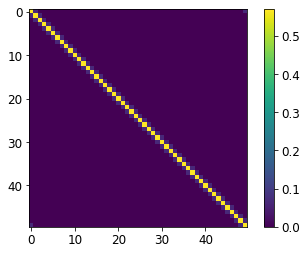

In [3]:
# First generate a random hamiltonian of the Huckel model
# i.e. alpha on the diagonal, and gamma on the off-diagonals to represent nearest neighbors
#    for now use random alpha and gamma
np.random.seed(75)
alpha = np.random.random()
gamma = np.random.random()
print(alpha)
print(gamma)

# define the dimensions of the Hamiltonian and how many elements to consider before cutoff
size = 50
H = pals.huckel_hamiltonian(alpha, gamma, size)
H_spect = linalg.eigvalsh(H)
print(H_spect)

# define a chemical potential mu (middle of eigenvalue spectrum)
num_electrons = int(0.5*H.shape[0])
index = int(num_electrons/1)
mu = (H_spect[index] + H_spect[index-1])/2
#mu = 0.45

plt.imshow(H.real)
plt.colorbar()

In [4]:
# Exact answers using Heaviside step function and Fermi-dirac statistics
# Heaviside - this simulates 0 tempurature

heav_exact = linalg.funm(H, lambda _: _ <= mu)

# Fermi-Dirac - this simulates finite temperature
beta = 300
ferm_exact = linalg.funm(H, lambda _: np.exp(-beta*(_ - mu))/(1+np.exp(-beta*(_ - mu))))

In [5]:
# perform our GCP and CP methods
numsteps = 10000
dbeta = beta/numsteps
ovlp = np.identity(H.shape[0], dtype=complex)
#inv_ovlp = linalg.inv(ovlp)
init_rho = ovlp/2

dmm_gcp_rho = gcp.rk4(gcp.rhs, init_rho, dbeta, H, ovlp, ovlp, mu, numsteps)
print(dmm_gcp_rho.trace())
print(mu)

init_rho = num_electrons/ovlp.trace() * ovlp
init_mu = H.trace()/ovlp.trace()
print(init_mu)
dmm_cp_rho, cp_mu = cp.rk4(cp.rhs, init_rho, dbeta, H, ovlp, ovlp, numsteps, num_electrons, ovlp, init_mu, beta)
print(dmm_cp_rho.trace())
print(cp_mu)

(25+0j)
0.5689402201192455
(0.5689402201192457+0j)
(25+0j)
(0.5689402201192457+0j)


In [6]:
cp_mu = cp.get_mu(dmm_cp_rho, H, ovlp, num_electrons, ovlp)

cp_ferm_exact = linalg.funm(H, lambda _: 1/(1+np.exp(beta*(_ - cp_mu))))

25.0


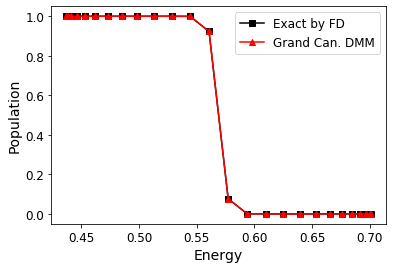

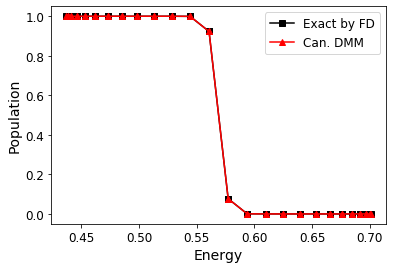

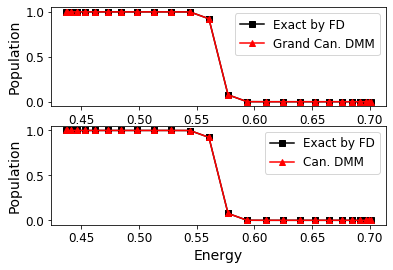

In [13]:
plt.figure(1)
plt.plot(H_spect, linalg.eigvalsh(ferm_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(H_spect, linalg.eigvalsh(dmm_gcp_rho)[::-1], 'r^-', label="Grand Can. DMM")
plt.ylabel("Population")
plt.xlabel("Energy")
plt.legend(numpoints=1)
plt.savefig("gc_huck_eigs.png", format='png', dpi=300)

print(linalg.eigvalsh(dmm_cp_rho).sum())
plt.figure(2)
plt.plot(H_spect, linalg.eigvalsh(cp_ferm_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(H_spect, linalg.eigvalsh(dmm_cp_rho)[::-1], 'r^-', label="Can. DMM")
plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig("c_huck_eigs.png", format='png', dpi=300)

fig = plt.figure(3)
ax = fig.subplots(2,1)
ax[0].plot(H_spect, linalg.eigvalsh(ferm_exact)[::-1], 'ks-', label="Exact by FD")
ax[0].plot(H_spect, linalg.eigvalsh(dmm_gcp_rho)[::-1], 'r^-', label="Grand Can. DMM")
ax[0].set_ylabel("Population")
ax[0].legend(numpoints=1)

ax[1].plot(H_spect, linalg.eigvalsh(cp_ferm_exact)[::-1], 'ks-', label="Exact by FD")
ax[1].plot(H_spect, linalg.eigvalsh(dmm_cp_rho)[::-1], 'r^-', label="Can. DMM")
ax[1].set_ylabel("Population")
ax[1].set_xlabel("Energy")
ax[1].legend(numpoints=1)
fig.savefig("huck_eigs.png", format='png', dpi=300)